# US birthrate Data

Let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).

In [2]:
import numpy as np
import pandas as pd

births = pd.read_csv('E:/aaaML Projects/data/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [4]:
print(type(births.year[0]))

<class 'numpy.int64'>


We can start to understand this data a bit more by using a pivot table. Let's add a decade column, and take a look at male and female births as a function of decade:

In [8]:
births['decade'] = 10* (births['year'] //10)
births.pivot_table('births', index='decade', columns='gender', aggfunc = sum)

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We see male births > female births. To see it visually we will plot it.

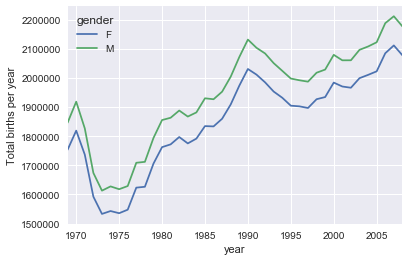

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # use Seaborn styles

# annual trend in births by gender
births.pivot_table('births', index='year', columns='gender', aggfunc = sum).plot()
plt.ylabel('Total births per year')

By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

#### Further data exploration
Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point. We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th). One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [10]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0]) 
# sig is  robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution

In [11]:
# using query method we will filter out rows with births outside the given condition

births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [12]:
# Next we set the day column to integers; previously it had been a string because some columns in the dataset 
# contained the value 'null':

births['day'] = births['day'].astype(int)

combine the day, month, and year to create a Date index (see Working with Time Series). This allows us to quickly compute the weekday corresponding to each row:

In [13]:
births.index = pd.to_datetime(10000 * births.year + 
                                100 * births.month + 
                                      births.day, format = '%Y%m%d')

births['dayofweek'] = births.index.dayofweek

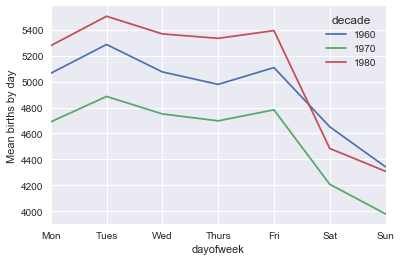

In [19]:
# plot births by weekday for several decades

import matplotlib as mpl

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc = 'mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Mean births by day'); # semicolon prevents printing any output

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.
To plot the mean number of births by the day of the year. Let's first group the data by month and day separately:

In [20]:
# result of pivot table is a multi-index over months and days
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

 To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [21]:
births_by_date.index = [pd.datetime(2012, month , day) 
                        for (month,day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year. From this, we can use the plot method to plot the data. It reveals some interesting trends:

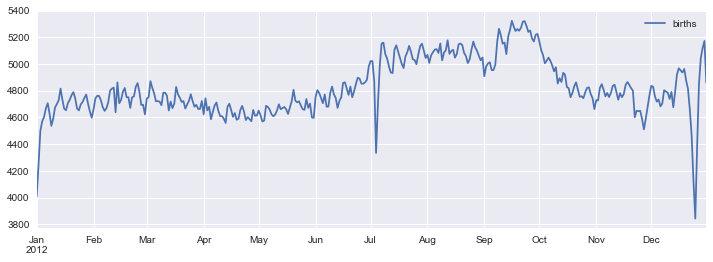

In [23]:
fig,ax = plt.subplots(figsize=(12,4))
births_by_date.plot(ax=ax);

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.